# Camden Cycling Analysis

Seeing as I am around the borough of Camden (in London) a lot due to my attending class at [University College London](http://www.ucl.ac.uk/) and because of the vast number of cyclists I see around me everyday in the area, just for practice I decided to explore some [open data](https://opendata.camden.gov.uk/Transport/Camden-Cycle-Counters/hwk2-xvrv) from two Camden Cycle Counters to see if I could find any patterns in the flow of cycle traffic in the borough. The hope is that the code below is replicable and the reader is able to follow along linearly through the analysis process.

## Import Statements

In [1]:
import os
from urllib.request import urlretrieve

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Get Data

In [2]:
#url of data source
URL = 'https://opendata.camden.gov.uk/api/views/hwk2-xvrv/rows.csv?accessType=DOWNLOAD' 

#function to only download data if needed ie. if the user doesn't already have it.
def get_camden_data(filename='Camden.csv', url=URL):
    if not os.path.exists(filename):
        urlretrieve(url, 'Camden.csv')
    """Read the csv file of bike counter data and parse the dates from 
    strings to appropriate European date format."""
    dateparse = lambda x: [pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for d in x]
    data = pd.read_csv('Camden.csv')
    data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%d/%m/%Y %I:%M:%S %p')
    df = data.set_index('Last Updated') #new dataframe with index as Last Updated
    return df

In [3]:
df = get_camden_data()
df.head() #check first few rows of data to see if expected columns are there.

,Site Name,Site Identifier,Hourly Count,Last Count,Total Count,Latest Day,Latest Week,Latest Month,Latest Year,Hour,...,Month,Year,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Location,Last Uploaded,Organisation URI
Last Updated,,,,,,,,,,,,,,,,,,,,,
2016-11-17 17:00:00,Royal College Street,100013432,212,2117.0,1223585.0,No,No,No,Yes,17.0,...,November,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",18/11/2016 08:00:10 AM,http://opendatacommunities.org/id/london-borou...
2016-06-23 11:00:00,Royal College Street,100013432,32,NaN,NaN,No,No,No,Yes,11.0,...,June,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...
2016-02-27 11:00:00,Royal College Street,100013432,23,NaN,NaN,No,No,No,No,11.0,...,February,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...
2017-01-27 13:00:00,Royal College Street,100013432,55,1671.0,1317359.0,No,No,No,Yes,13.0,...,January,2017,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",28/01/2017 08:00:10 AM,http://opendatacommunities.org/id/london-borou...
2017-04-12 01:00:00,Pancras Road,100024240,9,1878.0,578599.0,No,No,No,Yes,1.0,...,April,2017,529747,183410,-0.13074,51.53469,The approximate location of the cycle counter.,"(51.53469, -0.13074)",13/04/2017 08:00:13 AM,http://opendatacommunities.org/id/london-borou...


## Intial Data Exploration

In [4]:
df['Hourly Count'].describe() #summary stats for the hourly counts

count    33298.000000
mean        48.000120
std         63.667258
min          0.000000
25%          3.000000
50%         28.000000
75%         60.000000
max        546.000000
Name: Hourly Count, dtype: float64

In [5]:
print (df.index.min()) #print earliest Last Updated date in dataset
print (df.index.max()) #print latest Last Updated date in dataset

2015-07-01 00:00:00
2017-05-21 23:00:00


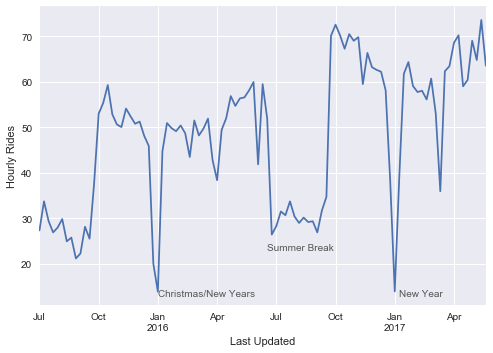

In [6]:
ax = df['Hourly Count'].resample('W').mean().plot() #resample hourly cycle count by week to reduce number of datapoints
ax.set_ylabel("Hourly Rides")

# Add labels to the plot
style = dict(size=10, color='#585858')
ax.text('2016-1-2', 13, "Christmas/New Years", **style)
ax.text('2017-1-2', 13, "New Year", **style)
ax.text('2016-6-15', 23, "Summer Break", **style)

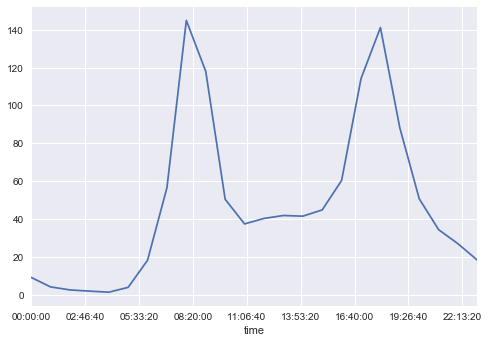

In [7]:
df['Hourly Count'].groupby(df.index.time).mean().plot() #Average hourly counts at each time of day over the dataset

In [8]:
pivoted = df.pivot_table('Hourly Count', index = df.index.time, columns = df.index.date)
pivoted.iloc[:5, :5] #Look at first part of pivoted data

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05
00:00:00,7.5,10.0,10.0,15.5,4.5
01:00:00,1.5,2.5,2.0,2.5,4.0
02:00:00,2.5,1.5,2.5,1.0,1.0
03:00:00,1.0,0.0,0.0,1.0,2.5
04:00:00,1.5,1.0,1.5,1.0,0.0


We now have a two dimensional dataframe where each column is a day in the dataset and each row corresponds to an hour during that day.

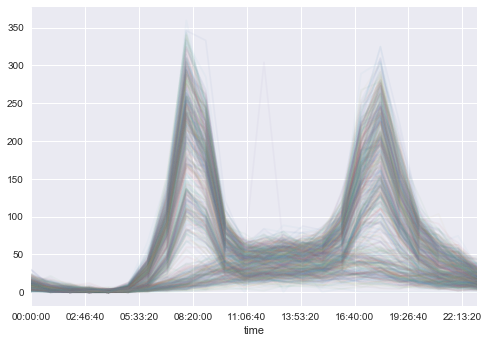

In [9]:
pivoted.plot(legend=False, alpha=0.05) #set opacity of lines to 0.05 allowing for easier visualization

Seeing the above chart - we have a line for each day of the year (for the 3 year period of this dataset). We can see that a bunch of days have a bi-modal 'commute' pattern with the spikes around the morning and evening rish hours. We also see lines (albeit a fewer number) not following the typical commute pattern with a gentle peak near midday. We can hypothesize that these lines represent the weekend cycle counts.

## Principal Component Analysis

In [10]:
X = pivoted.fillna(0).T.values
X.shape

(691, 24)

In [11]:
X2 = PCA(2, svd_solver='full').fit_transform(X)
X2.shape #two dimensional projection of the original data

(691, 2)

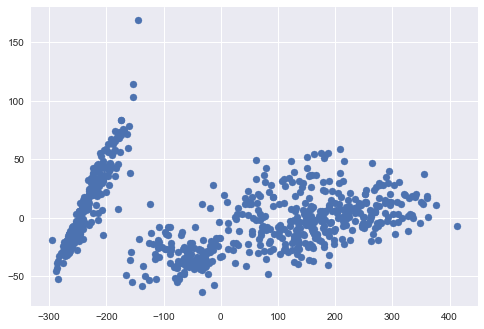

In [12]:
plt.scatter(X2[:, 0], X2[:, 1])

When we do this dimensionality reduction on this dataset, we see that there are two distinct clusters representing different types of days. Let's see if we can automatically identify these clusters.

## Unsupervised Clustering

In [13]:
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)

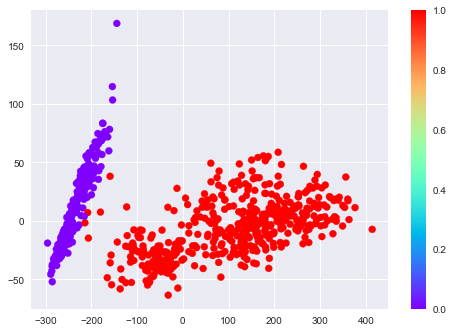

In [14]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()

Now we can see the partitioning of these two distinct clusters - into red and purple. Now it's worth checking out the commute pattern of just the portion of the data in each of these different clusters of days.

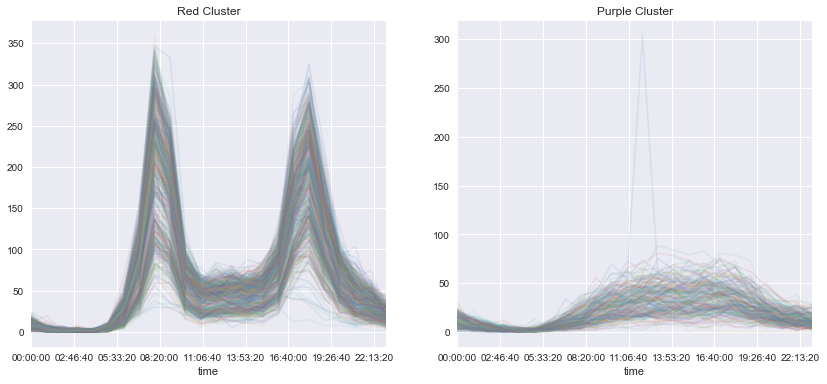

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[0]) #plot red cluster
ax[0].set_title('Red Cluster')
pivoted.T[labels ==0].T.plot(legend=False, alpha=0.1, ax=ax[1]) # plot purple cluster
ax[1].set_title('Purple Cluster')

## Comparing with day of week

In [16]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

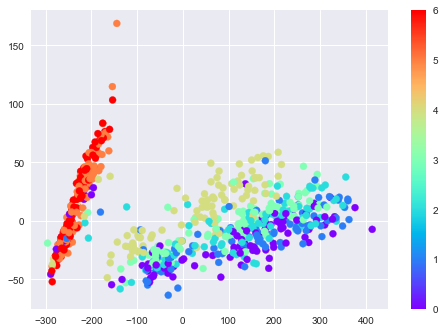

In [17]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow') #plotting with colors based on day of week.
plt.colorbar()

We can see from the day of week clustering above that the majority of days 0, 1, 2, 3, and 4 (Monday, Tuesday, Wednesday, Thursday, and Friday) belong in the cluster at the bottom and days 5 and 6 (Saturday and Sunday) belong to the other cluster. This makes sense - considering that weekends would definitely have fewer commuters riding on bikes. However, what's interesting is that in the predominantly red 'weekend' cluster, we can also see some weekdays interspersed (shown by the purple and light blue points in the red cluster above).

## Analyzing Outliers

In [18]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 1) & (dayofweek < 5)] #Filter to see only the days that are non-weekends but still fall under the 'weekend' cluster

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
               '2015-07-13', '2015-07-14',
               ...
               '2017-05-08', '2017-05-09', '2017-05-10', '2017-05-11',
               '2017-05-12', '2017-05-15', '2017-05-16', '2017-05-17',
               '2017-05-18', '2017-05-19'],
              dtype='datetime64[ns]', length=475, freq=None)